[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/MulticlassLogistic.ipynb)

# Multiclass Regression

In [279]:
import numpy as np
from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn import preprocessing
import random
random.seed(551)

# Simulate toy data

In [280]:
N = 150

X = np.column_stack((np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N)))

W_true = np.array([[0,1,0],
                   [0,0,1],
                   [1,0,0],
                   [0,0,1]])

a = np.matmul(X, W_true)
y = np.zeros_like(a)
y[np.arange(len(a)), a.argmax(1)] = 1

In [281]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100, tol=1e-3):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


Split the data into training, validation, and testing

In [282]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.66, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

Create Multinomial Logistic Regression model object

In [283]:
D = X.shape[1]
C = y.shape[1]

mlr = Multinomial_logistic(D, C)

Check gradients

In [284]:
# check grad
print(mlr.check_grad(X_train, y_train))

4.928106675016678e-17


Fitting the multinomial logistic model

iter 0: 28.507; 28.591
iter 1: 27.736; 27.789
iter 2: 27.021; 27.046
iter 3: 26.356; 26.357
iter 4: 25.736; 25.717
iter 5: 25.158; 25.122
iter 6: 24.618; 24.568
iter 7: 24.112; 24.052
iter 8: 23.638; 23.570
iter 9: 23.192; 23.119
iter 10: 22.771; 22.696
iter 11: 22.375; 22.299
iter 12: 22.000; 21.926
iter 13: 21.644; 21.574
iter 14: 21.307; 21.242
iter 15: 20.986; 20.928
iter 16: 20.680; 20.630
iter 17: 20.388; 20.347
iter 18: 20.109; 20.079
iter 19: 19.843; 19.823
iter 20: 19.587; 19.579
iter 21: 19.341; 19.346
iter 22: 19.105; 19.123
iter 23: 18.878; 18.909
iter 24: 18.659; 18.704
iter 25: 18.448; 18.508
iter 26: 18.244; 18.318
iter 27: 18.047; 18.136
iter 28: 17.856; 17.960
iter 29: 17.671; 17.790
iter 30: 17.493; 17.626
iter 31: 17.319; 17.468
iter 32: 17.151; 17.314
iter 33: 16.987; 17.165
iter 34: 16.828; 17.021
iter 35: 16.673; 16.881
iter 36: 16.523; 16.744
iter 37: 16.376; 16.612
iter 38: 16.234; 16.483
iter 39: 16.095; 16.358
iter 40: 15.959; 16.235
iter 41: 15.827; 16.116
it

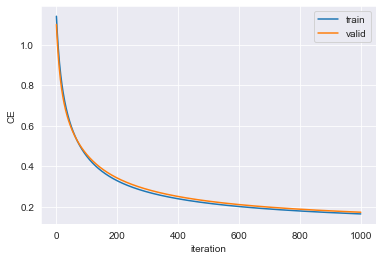

In [285]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, niter=1000)

plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.plot(ce_valid/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

From the above plot, we can see that the training and validation error curves both continue to decrease. Therefore, there is no sign of overfitting.

In [286]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

In [287]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print(train_accuracy)
print(valid_accuracy)
print(test_accuracy)

1.0
0.9615384615384616
0.9797979797979798


In [288]:
print(mlr.W)
print(W_true)

[[-0.25026762  3.16016891 -1.13885543]
 [-0.49662424 -1.28406867  3.14149206]
 [ 4.86496076 -1.77272719 -1.14990693]
 [-1.65678398  0.04347674  2.74801688]]
[[0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]]


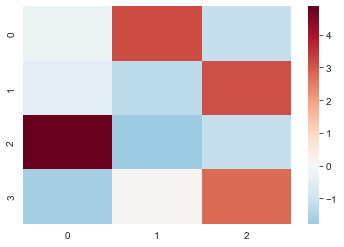

In [289]:
from seaborn import heatmap
W_hat = mlr.W
hmp = heatmap(W_hat, cmap='RdBu_r', center=0)
fig = hmp.get_figure()
fig.savefig("W_hat.png")

Plot as softmax

In [290]:
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=1).reshape(W_hat_transformed.shape[0], 1)
W_hat_transformed

array([[0.031556  , 0.95546703, 0.01297697],
       [0.02533239, 0.01152639, 0.96314122],
       [0.9962618 , 0.00130516, 0.00243304],
       [0.01132269, 0.06199598, 0.92668132]])

Now plot the softmax-transformed heatmap, which looks almost identical to groundtruth.

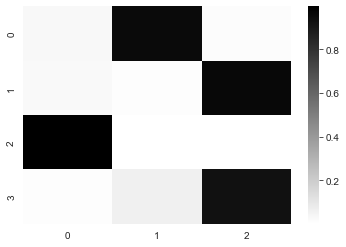

In [291]:
hmp = heatmap(W_hat_transformed, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("W_hat_transformed.png")

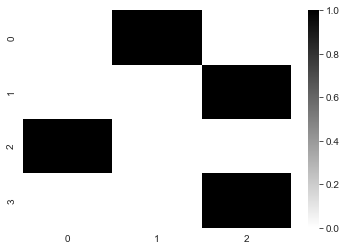

In [292]:
hmp = heatmap(W_true, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("W_true.png")

# Iris flower classification

In [293]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()

print(iris['target_names']) # print flower types
print(iris['feature_names']) # print flower feature names

X = iris.data
y_cat = iris.target

# convert array of class indices to one-hot encoded array
y = np.zeros((y_cat.size, y_cat.max() + 1))
y[np.arange(y_cat.size), y_cat] = 1

print(y)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 

Once again, we split the data into training, testing, and validation

In [294]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.66, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

N, C = y_train.shape

X_train = preprocessing.scale(X_train) # standardize input data
X_train = np.c_[X_train, np.ones(N)] # add one column to learn the linear intercept
X_valid = preprocessing.scale(X_valid)
X_valid = np.c_[X_valid, np.ones(X_valid.shape[0])]
X_test = preprocessing.scale(X_test)
X_test = np.c_[X_test, np.ones(X_test.shape[0])]

D = X_train.shape[1]

In [295]:
mlr = Multinomial_logistic(D, C)

# check grad
print(mlr.check_grad(X_train, y_train))

3.664480342552723e-19


iter 0: 17.722; 26.469
iter 1: 16.661; 25.622
iter 2: 15.769; 24.886
iter 3: 15.008; 24.234
iter 4: 14.349; 23.646
iter 5: 13.771; 23.111
iter 6: 13.259; 22.617
iter 7: 12.800; 22.158
iter 8: 12.385; 21.729
iter 9: 12.007; 21.325
iter 10: 11.661; 20.944
iter 11: 11.342; 20.584
iter 12: 11.046; 20.242
iter 13: 10.770; 19.917
iter 14: 10.513; 19.607
iter 15: 10.272; 19.313
iter 16: 10.046; 19.032
iter 17: 9.832; 18.764
iter 18: 9.630; 18.509
iter 19: 9.440; 18.265
iter 20: 9.259; 18.033
iter 21: 9.087; 17.811
iter 22: 8.924; 17.599
iter 23: 8.768; 17.397
iter 24: 8.620; 17.204
iter 25: 8.479; 17.020
iter 26: 8.344; 16.845
iter 27: 8.215; 16.677
iter 28: 8.091; 16.517
iter 29: 7.973; 16.364
iter 30: 7.859; 16.218
iter 31: 7.750; 16.079
iter 32: 7.645; 15.945
iter 33: 7.545; 15.818
iter 34: 7.448; 15.696
iter 35: 7.355; 15.580
iter 36: 7.265; 15.469
iter 37: 7.178; 15.363
iter 38: 7.095; 15.261
iter 39: 7.014; 15.164
iter 40: 6.937; 15.070
iter 41: 6.861; 14.981
iter 42: 6.789; 14.896
iter

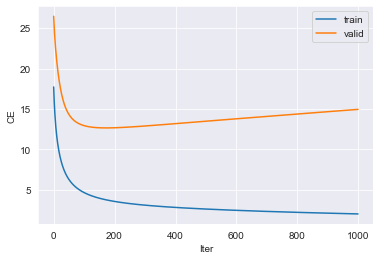

In [296]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, niter=1000)

plt.plot(ce_train, label='train')
plt.plot(ce_valid, label='valid')
plt.legend()
plt.xlabel("Iter")
plt.ylabel("CE")
plt.savefig("iris_training_ce.png", bbox_inches="tight", dpi=300)

In [297]:
mlr = Multinomial_logistic(D, C)
optimal_niter = ce_valid.argmin()
_, _ = mlr.fit(X_train, y_train, niter=optimal_niter) # retrain the model using best niter

iter 0: 27.727
iter 1: 24.459
iter 2: 21.885
iter 3: 19.847
iter 4: 18.219
iter 5: 16.901
iter 6: 15.819
iter 7: 14.919
iter 8: 14.160
iter 9: 13.512
iter 10: 12.951
iter 11: 12.462
iter 12: 12.030
iter 13: 11.645
iter 14: 11.300
iter 15: 10.987
iter 16: 10.702
iter 17: 10.442
iter 18: 10.202
iter 19: 9.979
iter 20: 9.772
iter 21: 9.579
iter 22: 9.398
iter 23: 9.228
iter 24: 9.068
iter 25: 8.917
iter 26: 8.773
iter 27: 8.636
iter 28: 8.507
iter 29: 8.383
iter 30: 8.265
iter 31: 8.152
iter 32: 8.044
iter 33: 7.940
iter 34: 7.840
iter 35: 7.744
iter 36: 7.652
iter 37: 7.563
iter 38: 7.477
iter 39: 7.395
iter 40: 7.315
iter 41: 7.237
iter 42: 7.163
iter 43: 7.090
iter 44: 7.020
iter 45: 6.952
iter 46: 6.886
iter 47: 6.822
iter 48: 6.760
iter 49: 6.700
iter 50: 6.641
iter 51: 6.584
iter 52: 6.528
iter 53: 6.474
iter 54: 6.422
iter 55: 6.370
iter 56: 6.320
iter 57: 6.271
iter 58: 6.224
iter 59: 6.177
iter 60: 6.132
iter 61: 6.088
iter 62: 6.044
iter 63: 6.002
iter 64: 5.961
iter 65: 5.920
i

Check classification accuracy on training, validation, and testing sets

In [298]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print(train_accuracy)
print(valid_accuracy)
print(test_accuracy)

0.96
0.8461538461538461
0.7070707070707071


Visualize feature weights for each flower class

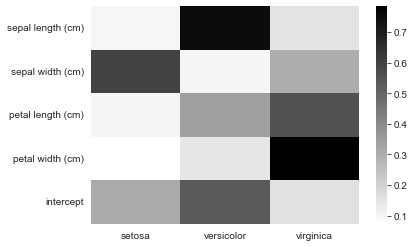

In [299]:
W_hat = mlr.W
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=1).reshape(W_hat_transformed.shape[0], 1)

import pandas as pd
iris = datasets.load_iris()
feature_names = iris['feature_names'].copy()
feature_names.append('intercept')
label_names = iris['target_names'].tolist()

W_hat_transformed_df = pd.DataFrame(W_hat_transformed, columns=label_names, index=feature_names)
hmp = heatmap(W_hat_transformed_df, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("iris_W_hat_transformed.png", bbox_inches="tight", dpi=300)